In [8]:
# Import libraries
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, Dense, Embedding, LSTM, GlobalMaxPooling1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [9]:
# Import preprocessing method
from preprocessing import preprocess

In [10]:
# Define constants
BATCH_SIZE = 128
ENCODED_VECTOR_SIZE = 300
LSTM_SIZE = 100
MAX_WORDS = 10000
NUM_CLASSES = 20
NUM_EPOCHS = 30
OUTPUT_SIZE = 100
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.1

In [11]:
# Load datasets
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
texts = newsgroups.data
labels = newsgroups.target

In [12]:
# Preprocess texts
preprocessed_texts = [preprocess(text) for text in texts]

# Instantiate tokenizer
# tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer = Tokenizer()

# Tokenize words from samples
tokenizer.fit_on_texts(preprocessed_texts)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences 
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences to all be same size
# padded_sequences = pad_sequences(sequences)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, shuffle=True)

In [13]:
# Load in embeddings
embeddings = api.load("word2vec-google-news-300")

# Create embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, index in tokenizer.word_index.items():
    if word in embeddings:
        embedding_matrix[index] = embeddings[word]

In [14]:
# Define CNN model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=ENCODED_VECTOR_SIZE, weights=[embedding_matrix], input_length=ENCODED_VECTOR_SIZE, trainable=False),
    Dropout(0.5),
    Conv1D(ENCODED_VECTOR_SIZE, 3, activation="relu"),
    MaxPooling1D(3),
    Conv1D(ENCODED_VECTOR_SIZE, 3, activation="relu"),
    MaxPooling1D(3),
    Conv1D(BATCH_SIZE, 3, activation="relu"),
    MaxPooling1D(3),
    Conv1D(BATCH_SIZE, 3, activation="relu"),
    Dropout(0.5),
    LSTM(LSTM_SIZE),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
initial_lr = 0.001
lr_scheduler = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=10000, decay_rate=0.95)
optimizer = Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          44484000  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 298, 300)          270300    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 300)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 97, 300)           270300    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 300)          0         
 1D)                                                    

In [15]:
# Train the model
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/30
106/106 [==============================] - 75s 580ms/step - loss: 2.5653 - accuracy: 0.1487 - val_loss: 2.0534 - val_accuracy: 0.2593
Epoch 2/30
106/106 [==============================] - 56s 526ms/step - loss: 1.8968 - accuracy: 0.3063 - val_loss: 1.6310 - val_accuracy: 0.4158
Epoch 3/30
106/106 [==============================] - 63s 593ms/step - loss: 1.5821 - accuracy: 0.4201 - val_loss: 1.3973 - val_accuracy: 0.4894
Epoch 4/30
106/106 [==============================] - 61s 575ms/step - loss: 1.3747 - accuracy: 0.4943 - val_loss: 1.2309 - val_accuracy: 0.5531
Epoch 5/30
106/106 [==============================] - 58s 549ms/step - loss: 1.2495 - accuracy: 0.5463 - val_loss: 1.1055 - val_accuracy: 0.6094
Epoch 6/30
106/106 [==============================] - 61s 576ms/step - loss: 1.1300 - accuracy: 0.6047 - val_loss: 1.0277 - val_accuracy: 0.6592
Epoch 7/30
106/106 [==============================] - 62s 585ms/step - loss: 1.0232 - accuracy: 0.6477 - val_loss: 0.9385 - val_ac

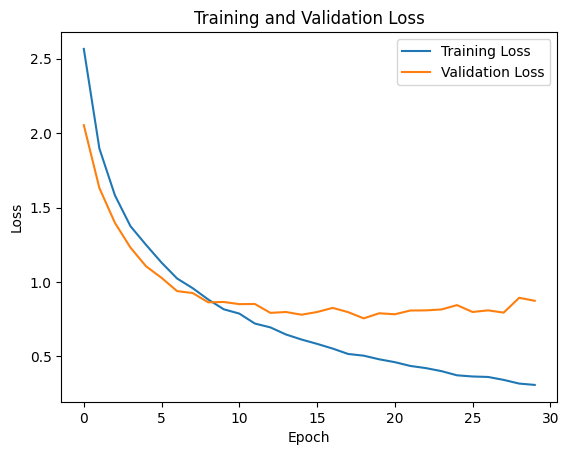

In [16]:
# Plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
confusion_matrix = confusion_matrix(y_pred=predictions, y_true=y_test)
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: {confusion_matrix}")

118/118 [==============================] - 6s 43ms/step
Accuracy: 0.7854111405835543
Confusion Matrix: [[111   1   0   0   1   0   2   2   2   0   0   1   0   1   2  19   2   1
    0  19]
 [  1 151   9   4   3  11   8   0   1   0   0   1   9   0   3   1   0   0
    0   0]
 [  0  17 131  17  10   7   6   0   2   0   0   1   2   0   0   0   0   1
    0   0]
 [  0   3  27 110  42   8   6   0   0   1   0   0  10   1   0   2   0   0
    0   0]
 [  0   7   6  12 139   2   3   0   0   0   0   1  13   0   1   1   0   0
    0   0]
 [  0  24   7   4   3 164   3   0   1   0   0   1   1   0   1   0   0   1
    0   0]
 [  0   2   1   4  11   2 134   4   2   4   2   0   8   0   3   2   1   0
    0   1]
 [  0   1   0   0   2   0   4 182   6   0   0   2   6   0   0   0   3   0
    0   1]
 [  1   2   0   0   1   0   4  11 166   0   2   1   2   0   3   0   0   2
    1   0]
 [  0   3   0   2   0   0   4   0   1 177   9   0   0   0   1   0   0   2
    0   1]
 [  0   0   0   1   1   2   0   1   0   7 206  